#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План выполнения проекта**

Сохранена предложенная структура проекта    
После каждого пункта следуют выводы и в заключение подводится общий итог

- 1 Подготовка данных
    - импорт библиотек
    - открытие файла данных
- 2 Анализ датасета
- 3 Обучение моделей
    - подбор моделей для регрессии
    - выбор лучших моделей
    - подбор основных гиперпараметров для этих моделей
- 4 Тестирование
    - выбор лучшей модели и ее оценка на тестовой выборке
    - подведение итогов
- 5 Чек-лист проверки

## Подготовка

In [1]:
import pandas as pd
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

plt.rcParams["figure.figsize"] = (20, 5)

In [2]:
def load_df(file_name, sep=',', path='https://code.s3.yandex.net', **params):
    
    pth1 = file_name
    pth2 = path + file_name

    if os.path.exists(pth1):
        return pd.read_csv(pth1, **params)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2, **params)
    else:
        print(f"Cannot find file {file_name} in the specified folders, trying remote folder")
        return pd.read_csv(pth2, **params)

In [3]:
df = load_df('/datasets/taxi.csv', path='https://code.s3.yandex.net', index_col=[0], parse_dates=[0])
df.info()
df.head()

Cannot find file /datasets/taxi.csv in the specified folders, trying remote folder
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
print('Временной ряд монотонный:', df.index.is_monotonic_increasing)
df = df.resample('1H').sum()
df.head()

Временной ряд монотонный: True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Итоги п.1**
- датасет загружен успешно
- пропусков нет
- временной ряд монотонный
- произведено ресемплирование по 1 часу

## Анализ

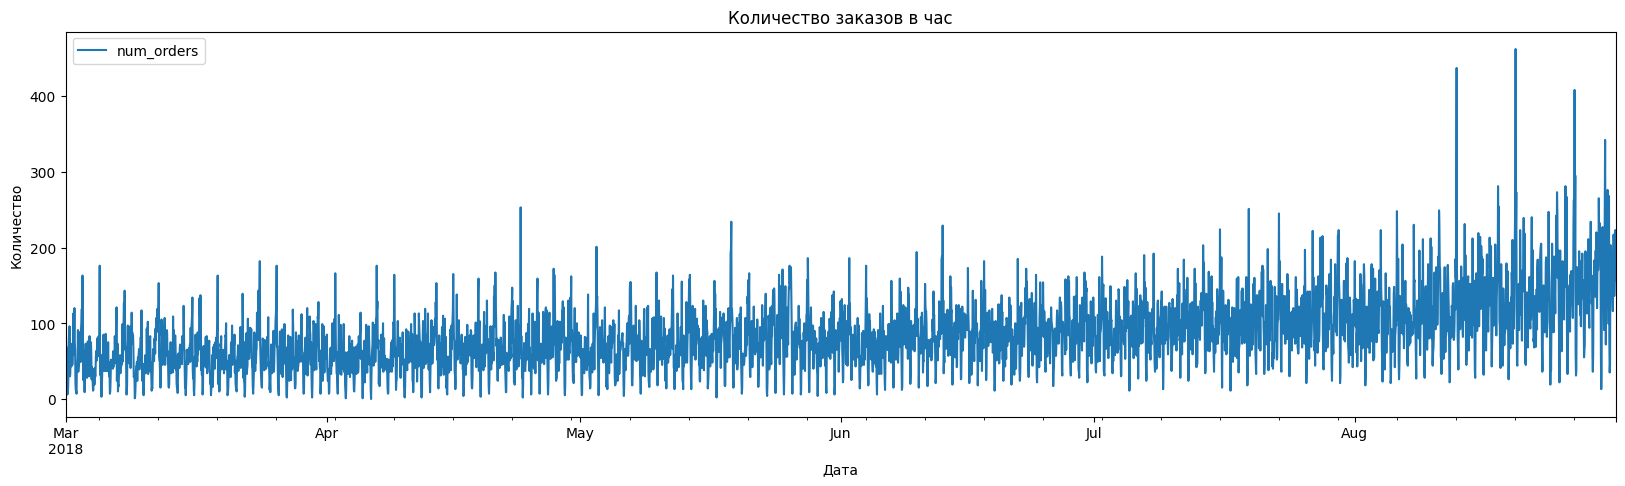

In [6]:
df.plot()
plt.xlabel("Дата") 
plt.ylabel("Количество") 
plt.title("Количество заказов в час");

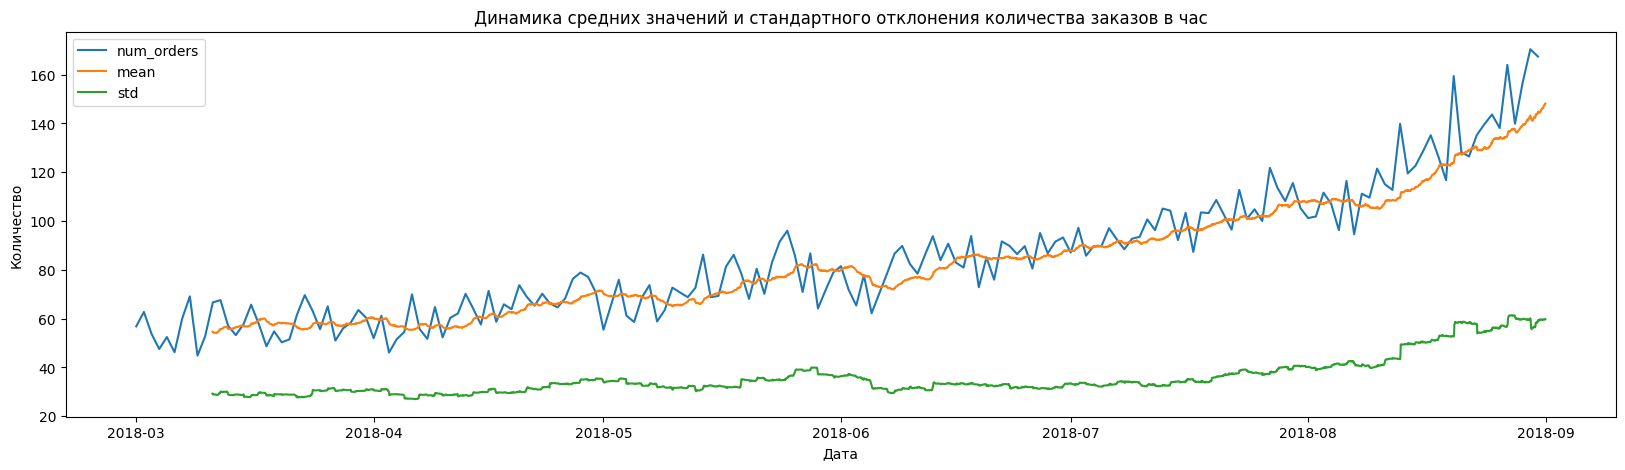

In [7]:
plt.plot(df['num_orders'].resample('1D').mean(), label='num_orders')
plt.plot(df['num_orders'].rolling(24*10).mean(), label='mean')
plt.plot(df['num_orders'].rolling(24*10).std(), label='std')
plt.legend()
plt.xlabel("Дата") 
plt.ylabel("Количество") 
plt.title("Динамика средних значений и стандартного отклонения количества заказов в час");

Среднее значение со временем увеличивается, стандартное отклонение немного увеличивается в конце ряда.  
Временной ряд нестационарен, разлагаем на составляющие.

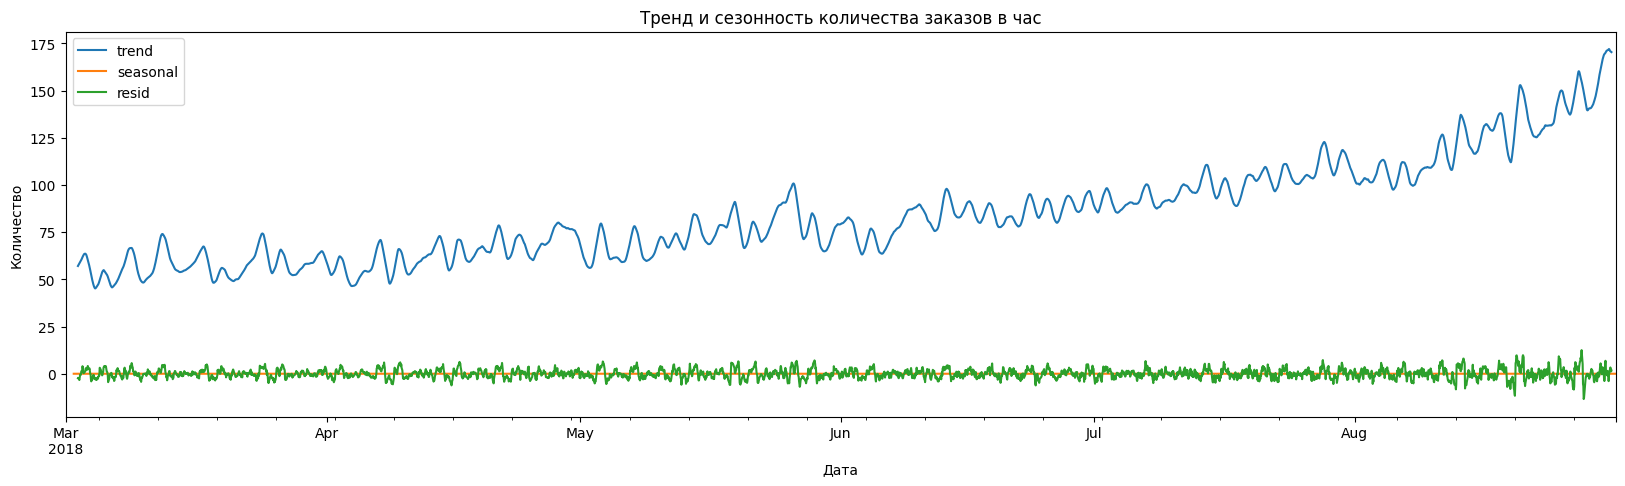

In [8]:
decomposed = seasonal_decompose(df)
decomposed.trend.rolling(24).mean().plot()
decomposed.seasonal.rolling(24).mean().plot()
decomposed.resid.rolling(24).mean().plot()
plt.legend()
plt.xlabel("Дата") 
plt.ylabel("Количество") 
plt.title("Тренд и сезонность количества заказов в час");

Видим четко восходящий тренд, сезонность по годам из-за недостатка данных не проявляется, остаток декомпозиции около нуля.  
Рассмотрим интуитивно понятные колебания количества заказов в час в течение дня.

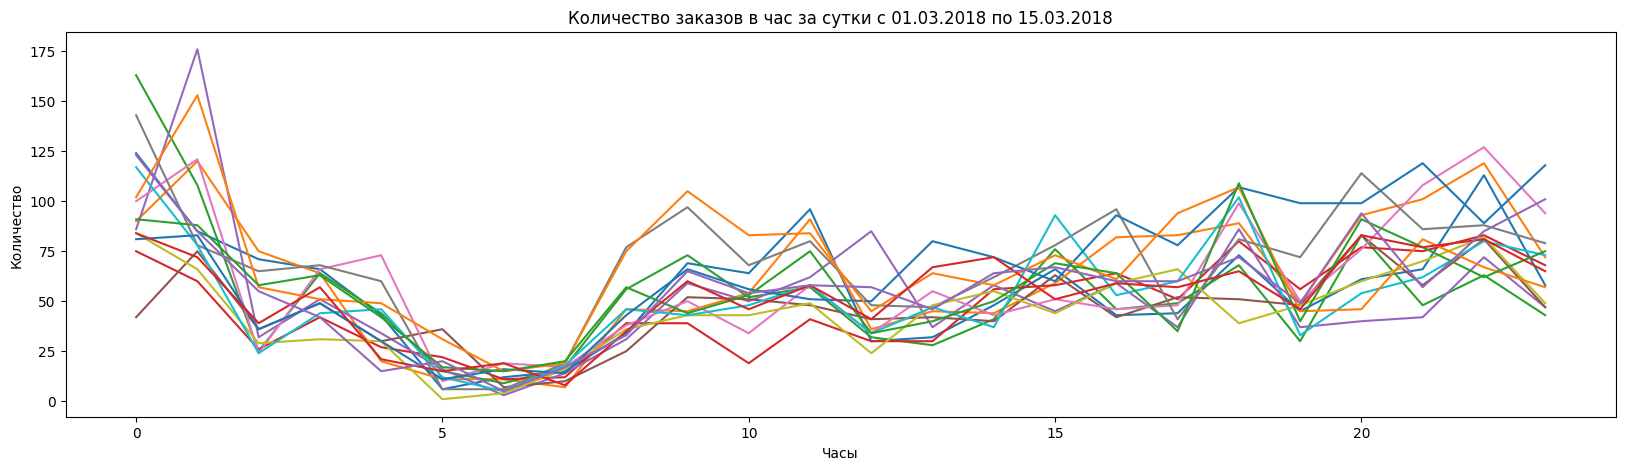

In [9]:
for d in pd.date_range(start='2018-03-01', end='2018-03-15'):
    plt.plot(range(24), df.loc[d.strftime("%Y-%m-%d")]['num_orders'])
plt.xlabel("Часы") 
plt.ylabel("Количество") 
plt.title("Количество заказов в час за сутки с 01.03.2018 по 15.03.2018");

Видим четкую зависимость количества заказов от времени суток, с минимумом в утренние часы и максимумом в ночные.

Для приведения ряда к стационарному создадим столбец разностей.

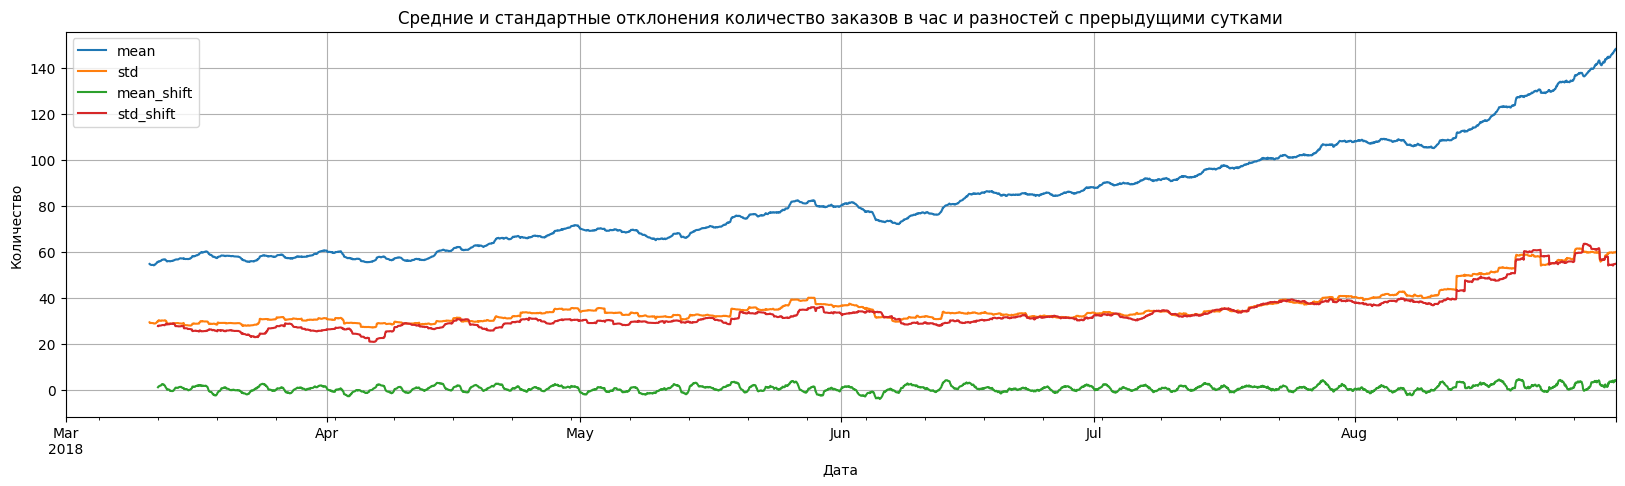

In [10]:
def plot_mean_std_shift(data, days=10):
    data['shift'] = data['num_orders'] - data['num_orders'].shift(24)
    data['mean'] = data['num_orders'].rolling(24*days).mean()
    data['std'] = data['num_orders'].rolling(24*days).std()
    data['mean_shift'] = data['shift'].rolling(24*days).mean()
    data['std_shift'] = data['shift'].rolling(24*days).std()
    data[['mean', 'std', 'mean_shift', 'std_shift']].plot(grid=True)
    plt.xlabel("Дата") 
    plt.ylabel("Количество") 
    plt.title("Средние и стандартные отклонения количество заказов в час и разностей с прерыдущими сутками");
data = df.copy()
plot_mean_std_shift(data)


Среднее значение разности близко к 0, стандартное отклонение не изменилось, ряд разностей близок к стационарному.

Временной ряд обладает сезонностью по суткам, созданим суточные, а также другие календарные признаки.

In [11]:
data['hour'] = data.index.hour
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

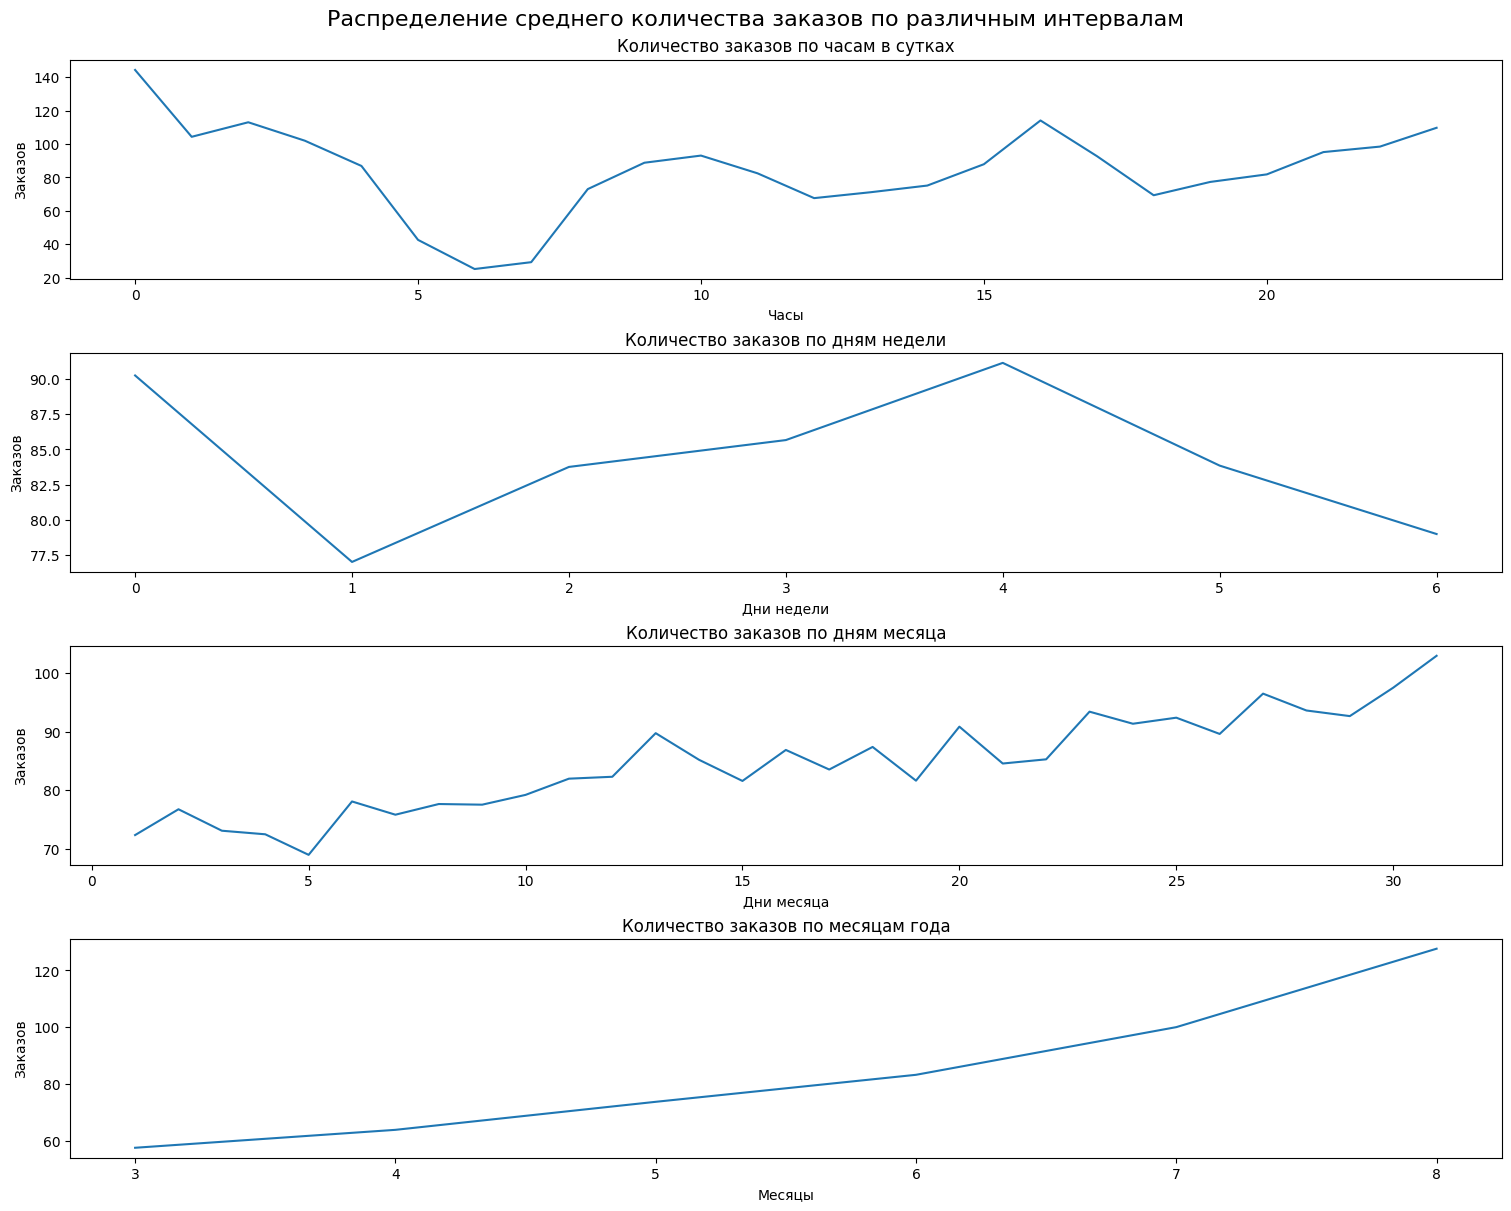

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(15,12), constrained_layout=True)

ax[0].plot(data.groupby('hour').mean().num_orders)
ax[0].set_title('Количество заказов по часам в сутках')
ax[0].set_xlabel('Часы')
ax[0].set_ylabel('Заказов')

ax[1].plot(data.groupby('dayofweek').mean().num_orders)
ax[1].set_title('Количество заказов по дням недели')
ax[1].set_xlabel('Дни недели')
ax[1].set_ylabel('Заказов')

ax[2].plot(data.groupby('day').mean().num_orders)
ax[2].set_title('Количество заказов по дням месяца')
ax[2].set_xlabel('Дни месяца')
ax[2].set_ylabel('Заказов')

ax[3].plot(data.groupby('month').mean().num_orders)
ax[3].set_title('Количество заказов по месяцам года')
ax[3].set_xlabel('Месяцы')
ax[3].set_ylabel('Заказов')

fig.suptitle('Распределение среднего количества заказов по различным интервалам', fontsize=16)
plt.show()

По часам суток видим картину, полученную ранее. Также видим зависимость от дня недели (максимальные значения в понедельник и пятницу).  
Количество заказов в месяце и по месяцам года отражают выявленный ранее восходящий тренд.  
Все признаки значимые.

In [13]:
def make_features(data, max_lag, rolling_mean_size=1):
    data = data.copy()
    multiplier = 24
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(multiplier, max_lag*multiplier + 1, multiplier):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size*multiplier, closed='left').mean()
    return data.dropna()

Найдем оптимальное количество признаков для отстающих значений.

In [14]:
def rmse(y_real, y_pred, round_digits=10):
    return round(mean_squared_error(y_real, y_pred, squared=False), round_digits)

In [15]:
#def get_split_size(data, test_size_ratio = 0.1):
#    return round(data.shape[0]*(1 - test_size_ratio))

def fit_predict_rmse(data, msg=''):    
    train = data[:round(data.shape[0]*0.9)]
    target = ['num_orders']
    features = [x for x in list(train.columns) if x not in target]
    model = LinearRegression().fit(train[features], train[target])
    y_pred_train = model.predict(train[features])
    return rmse(train[target], y_pred_train, 4)

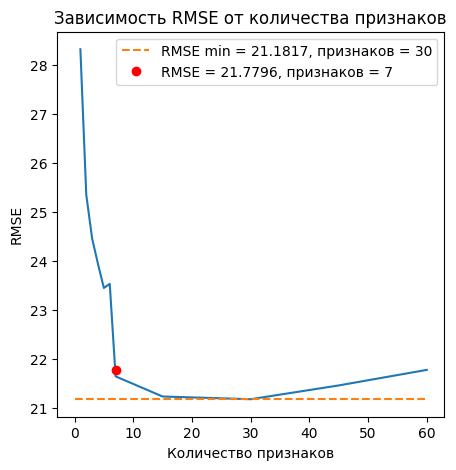

In [16]:
rmse_arr=[]
rmse_min=100
feat_min = 0
for i in list(range(1, 8)) + [15, 30, 45, 60]:
    data = df.copy()
    data = make_features(data, i)
    rmse_new = fit_predict_rmse(data, 'features')
    if rmse_new < rmse_min:
        rmse_min = rmse_new
        feat_min = i
    rmse_arr.append(fit_predict_rmse(data, 'features'))

plt.figure(figsize=(5, 5))
plt.plot(list(range(1, 8)) + [15, 30, 45, 60], rmse_arr)
plt.plot([0, 60], [rmse_min, rmse_min], '--', label=f'RMSE min = {rmse_min}, признаков = {feat_min}')
rmse_new = fit_predict_rmse(make_features(df.copy(), i), 'features')
plt.plot( 7, rmse_new, 'ro', label=f'RMSE = {rmse_new}, признаков = 7') 
plt.title('Зависимость RMSE от количества признаков')
plt.xlabel('Количество признаков')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Лучшее значение - 30 признаков, отражающих месячный цикл, но количество признаков большое, для дальнейшего подбора гиперпараметров оставим 7 - значение в точке "локтя", после которого нет резкого улучшения.

In [17]:
# Протестируем 7 признаков с разными размерами окна
# Убедимся, что лучшее значение - по умолчанию = 1
for i in range(1, 11):
    data = df.copy()
    data = make_features(data, 7, i)
    print(f'rolling size = {i}, RMSE = {fit_predict_rmse(data)}')

rolling size = 1, RMSE = 21.6469
rolling size = 2, RMSE = 21.7943
rolling size = 3, RMSE = 21.7978
rolling size = 4, RMSE = 21.8044
rolling size = 5, RMSE = 21.8056
rolling size = 6, RMSE = 21.7914
rolling size = 7, RMSE = 21.785
rolling size = 8, RMSE = 21.7495
rolling size = 9, RMSE = 21.7929
rolling size = 10, RMSE = 21.8445


In [18]:
data = make_features(df.copy(), 7)
train = data[:round(data.shape[0]*0.9)]
test = data[round(data.shape[0]*0.9):]
target = ['num_orders']
features = [x for x in list(train.columns) if x not in target]
print(f'Train size: {train.shape[0]}, test size: {test.shape[0]}')
data.head()

Train size: 3823, test size: 425


,num_orders,hour,month,day,dayofweek,lag_24,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,8,3,100.0,42.0,86.0,75.0,163.0,90.0,124.0,60.041667
2018-03-08 01:00:00,78,1,3,8,3,121.0,75.0,176.0,60.0,108.0,120.0,85.0,61.833333
2018-03-08 02:00:00,65,2,3,8,3,24.0,36.0,32.0,26.0,25.0,75.0,71.0,60.041667
2018-03-08 03:00:00,68,3,3,8,3,66.0,49.0,51.0,42.0,64.0,64.0,66.0,61.750000
2018-03-08 04:00:00,60,4,3,8,3,73.0,30.0,34.0,27.0,44.0,20.0,43.0,61.833333


**Итоги п.2**
- датасет обладает общим восходящим трендом
- имеется суточная и недельная сезонность
- добавлены календарные признаки
- добавлены отстающие значения, эквивалентные недельным данным (7 дней)

## Обучение

Для подбора реализуем поиск по сетке с кросс-валидацией.  
Для тестирования возьмем алгоритмы линейной регорессии, алгоритмы с регуляризацией, дерево решений, случайный лес и пару методов градиентного бустинга.

In [19]:
def grid_search_cv(X, y, model_params, cv=5, verbose=0, scoring='neg_root_mean_squared_error'):
    
    best_model = ['', '', 100]
    for model_name, params in model_params.items():
        grid_search = GridSearchCV(estimator=eval(model_name), 
                                   param_grid=params,
                                   cv=cv, 
                                   scoring=scoring, 
                                   verbose=verbose)
        grid_search.fit(X, y)
        print(f'{model_name} : {grid_search.best_params_}, RMSE: {round(-grid_search.best_score_,4)}')
        if -grid_search.best_score_ < best_model[2]:
            best_model = [grid_search.best_estimator_, grid_search.best_params_, round(-grid_search.best_score_,4)]

    print('='*50)
    print(f'Best model: {best_model}')

    return best_model[0]

In [20]:
%%time

from catboost import CatBoostRegressor

tscv = TimeSeriesSplit(n_splits=5)

model_params = {
    'LinearRegression()': {},
    'Ridge()': {'alpha': [0.01, 0.1, 0.2, 0.3, 1, 10, 100, 500]},
    'Lasso()': {'alpha': [0.01, 0.1, 0.2, 0.5]}, 
    'ElasticNet()': {'alpha': [0.01, 0.05, 0.1, 0.2, 0.5], 'l1_ratio': [0.1, 0.5, 0.9]},
    'DecisionTreeRegressor(random_state=42)': {'min_samples_leaf':[1, 3, 7, 10], 
                                                                            'max_depth': [None, 5, 10, 15], 
                                                                            'max_leaf_nodes':[None, 10, 30, 50, 80]},
    'RandomForestRegressor(random_state=42)': {'n_estimators': [100, 300], 'max_depth' : [5, 10, 15]},
    'XGBRegressor(random_state=42, verbosity=0)': {'eta': [0.01, 0.2], 'max_depth': [3, 10]},
    'LGBMRegressor(random_state=42, verbosity=-1)': {'learning_rate': [0.01, 0.2], 'max_depth': [3, 10]},
    'CatBoostRegressor(random_state=42, verbose=0)': {'learning_rate': [0.01, 0.2], 'depth': [3, 10]}
}

best_model = grid_search_cv(train[features], np.ravel(train[target]), model_params, cv=tscv)

LinearRegression() : {}, RMSE: 22.4323
Ridge() : {'alpha': 100}, RMSE: 22.3282
Lasso() : {'alpha': 0.2}, RMSE: 22.354
ElasticNet() : {'alpha': 0.1, 'l1_ratio': 0.1}, RMSE: 22.3406
DecisionTreeRegressor(random_state=42) : {'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 10}, RMSE: 25.7942
RandomForestRegressor(random_state=42) : {'max_depth': 10, 'n_estimators': 300}, RMSE: 23.0398
XGBRegressor(random_state=42, verbosity=0) : {'eta': 0.2, 'max_depth': 3}, RMSE: 23.5849
LGBMRegressor(random_state=42, verbosity=-1) : {'learning_rate': 0.2, 'max_depth': 3}, RMSE: 23.5653
CatBoostRegressor(random_state=42, verbose=0) : {'depth': 3, 'learning_rate': 0.01}, RMSE: 22.6963
Best model: [Ridge(alpha=100), {'alpha': 100}, 22.3282]
CPU times: total: 1min 22s
Wall time: 2min 49s


**Итоги п.3**
- для обучения были выбраны различные алгоритмы
- проведен поиск по сетке с кросс-валидацией
- чуть лучше остальных оказался алгоритм Ridge

## Тестирование

Проверка на адекватность:

In [21]:
print(f"Средний объём заказов в день: {round(test['num_orders'].mean(), 4)}")
pred_median = np.ones(test.shape[0]) * train['num_orders'].median()
print(f"RMSE для прогноза по константной модели (медиане) : {rmse(test['num_orders'], pred_median, 4)}")
pred_previous = test['num_orders'].shift().fillna(train['num_orders'][-1])
print(f"RMSE для прогноза по предыдущему значению: {rmse(test['num_orders'], pred_previous, 4)}")

Средний объём заказов в день: 140.0871
RMSE для прогноза по константной модели (медиане) : 87.0392
RMSE для прогноза по предыдущему значению: 58.8197


In [22]:
y_pred_test = best_model.predict(test[features])
print(f'Лучшая модель: {best_model}')
print(f'RMSE тестовой выборки: {rmse(test[target], y_pred_test, 4)}')

Лучшая модель: Ridge(alpha=100)
RMSE тестовой выборки: 34.2762


**Итоги п.3**
- обученная модель прошла проверку на адекватность
- RMSE по тестовой выборке ниже целевого значения (48)

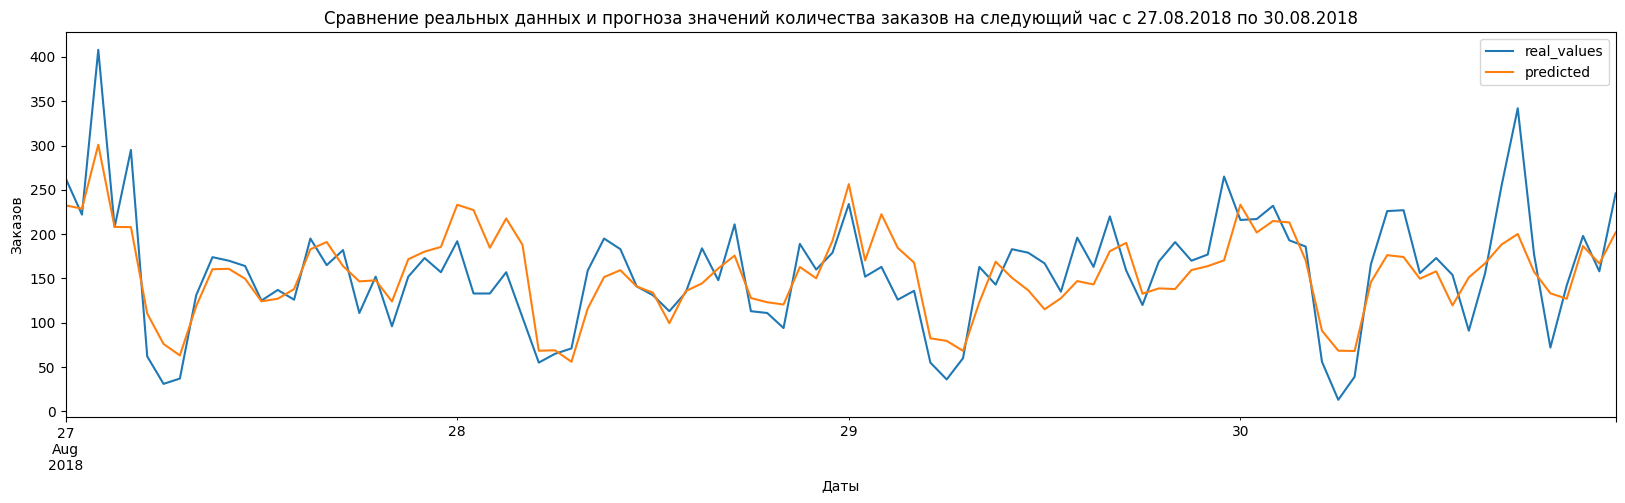

In [23]:
test_plot=test.copy()[['num_orders']]
test_plot.rename(columns={"num_orders": "real_values"}, inplace=True)
test_plot['predicted'] = y_pred_test.tolist()
fig = test_plot.loc['2018-08-27':'2018-08-30'].plot()
fig.set_title('Сравнение реальных данных и прогноза значений количества заказов на следующий час с 27.08.2018 по 30.08.2018')
fig.set_xlabel('Даты')
fig.set_ylabel('Заказов');

**Итоги проекта**
- заказчиком была поставлена задача прогнозирования количества заказов такси на следующий час на основе анализа исторических данных
- датасет загружен успешно
- временной ряд монотонный, произведено ресемплирование
- датасет обладает общим восходящим трендом, имеется суточная и недельная сезонность
- добавлены календарные признаки и отстающие значения
- проведен поиск по сетке с кросс-валидацией, лучшей оказалась модель, основанная на алгоритме Ridge
- обученная модель прошла проверку на адекватность, MAE по тестовой выборке ниже целевого значения
- примененная методика подходит для получения модели, предсказывающей количество заказов такси на следующий час с заданной точностью
- полученные результаты можно улучшить применением более сложных и точных методов (ARIMA, ETS, нейронные сети и т.д.)